# Machine Learning Pipeline - Feature Engineering

In the following notebooks, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. Data Analysis
2. **Feature Engineering**
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring


We will use the house price dataset available on [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). See below for more details.

===================================================================================================

## Predicting Sale Price of Houses

The aim of the project is to build a machine learning model to predict the sale price of homes based on different explanatory variables describing aspects of residential houses.


### Why is this important? 

Predicting house prices is useful to identify fruitful investments, or to determine whether the price advertised for a house is over or under-estimated.


### What is the objective of the machine learning model?

We aim to minimise the difference between the real price and the price estimated by our model. We will evaluate model performance with the:

1. mean squared error (mse)
2. root squared of the mean squared error (rmse)
3. r-squared (r2).


### How do I download the dataset?

- Visit the [Kaggle Website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

- Remember to **log in**

- Scroll down to the bottom of the page, and click on the link **'train.csv'**, and then click the 'download' blue button towards the right of the screen, to download the dataset.

- The download the file called **'test.csv'** and save it in the directory with the notebooks.


**Note the following:**

-  You need to be logged in to Kaggle in order to download the datasets.
-  You need to accept the terms and conditions of the competition to download the dataset
-  If you save the file to the directory with the jupyter notebook, then you can run the code as it is written here.

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [3]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [4]:
# load dataset
data = pd.read_csv('train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1200, 8)


,id,age,sex,bmi,children,smoker,region,charges
0,1,45,male,46.561704,5,no,southeast,0
1,2,18,female,23.572081,3,no,southwest,0
2,4,28,female,38.670352,0,no,southeast,0
3,5,46,female,45.614196,0,no,southwest,0
4,10,27,male,38.769610,0,no,northeast,0


# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

- mean
- mode
- exponents for the yeo-johnson
- category frequency
- and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [5]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

target = 'charges'

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['id', target], axis=1), # predictive variables
    data[target], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1080, 6), (120, 6))

# Feature Engineering

In the following cells, we will engineer the variables of the House Price Dataset so that we tackle:

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
5. Put the variables in a similar scale

## Target

We apply the logarithm.
but data "y" include data "0", so we can't apply the logarithm.

In [ ]:
# y_train = np.log(y_train)
# y_test = np.log(y_test)

## Missing values

### Categorical variables

We will replace missing values with the string "missing" in those variables with a lot of missing data. 

Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values. 

This is common practice.

In [6]:
# let's identify the categorical variables
# we will capture those of type object

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# MSSubClass is also categorical by definition, despite its numeric values
# (you can find the definitions of the variables in the data_description.txt
# file available on Kaggle, in the same website where you downloaded the data)

# lets add MSSubClass to the list of categorical variables
# cat_vars = cat_vars + ['MSSubClass']

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# number of categorical variables
print(len(cat_vars))
cat_vars

3


['sex', 'smoker', 'region']

In [7]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [8]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]

In [9]:
with_string_missing

[]

In [10]:
# replace missing values with new label: "Missing"

X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

In [11]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = X_train[var].mode()[0]
    
    print(var, mode)
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

In [12]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

Series([], dtype: float64)

In [13]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing indicator variable
- and then replace the missing values in the original variable with the mean

In [14]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'pm25_mid'
]

# number of numerical variables
len(num_vars)

3

In [15]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

Series([], dtype: float64)

In [16]:
# replace missing values as we described above

for var in vars_with_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

Series([], dtype: float64)

In [17]:
# check that test set does not contain null values in the engineered variables

[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [18]:
# check the binary missing indicator variables

# X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

## Temporal variables

### Capture elapsed time

We learned in the previous notebook, that there are 4 variables that refer to the years in which the house or the garage were built or remodeled. 

We will capture the time elapsed between those variables and the year in which the house was sold:

In [19]:
# def elapsed_years(df, var):
#     # capture difference between the year variable
#     # and the year in which the house was sold
#     df[var] = df['YrSold'] - df[var]
#     return df

In [20]:
# for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
#     X_train = elapsed_years(X_train, var)
#     X_test = elapsed_years(X_test, var)

In [21]:
# # now we drop YrSold
# X_train.drop(['YrSold'], axis=1, inplace=True)
# X_test.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the logarightm the positive numerical variables in order to get a more Gaussian-like distribution.

今回は対数変換を適用できるデータが無いので、何もしない。

In [22]:
# for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
#     X_train[var] = np.log(X_train[var])
#     X_test[var] = np.log(X_test[var])

In [23]:
# # check that test set does not contain null values in the engineered variables
# [var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_test[var].isnull().sum() > 0]

In [24]:
# # same for train set
# [var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] if X_train[var].isnull().sum() > 0]

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea.

In [25]:
yeo_johnson_vars = [
#     "co_cnt", "co_max",
#     "o3_cnt", "o3_min", "o3_max", "o3_var",
#     "so2_cnt", "so2_max",
#     "no2_cnt", "no2_max",
#     "temperature_cnt", "temperature_min", "temperature_var",
#     "humidity_cnt", "humidity_var",
#     "pressure_cnt", "pressure_var",
#     "ws_cnt", "ws_min", "ws_mid", "ws_max", "ws_var",
#     "dew_cnt", "dew_var"    
]

In [26]:
# # the yeo-johnson transformation learns the best exponent to transform the variable
# # it needs to learn it from the train set: 
for var in yeo_johnson_vars:
    X_train[var], param = stats.yeojohnson(X_train[var])

    # # and then apply the transformation to the test set with the same
    # # parameter: see who this time we pass param as argument to the 
    # # yeo-johnson
    X_test[var] = stats.yeojohnson(X_test[var], lmbda=param)

    print(param)

In [27]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [28]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize skewed variables

There were a few variables very skewed, we would transform those into binary variables.

In [29]:
skewed = [
#     'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
#     '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_test[var] = np.where(X_test[var]==0, 0, 1)

## Categorical variables

### Apply mappings

These are variables which values have an assigned order, related to quality. For more information, check Kaggle website.

In [30]:
# # re-map strings to numbers, which determine quality

# qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

# qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
#              'HeatingQC', 'KitchenQual', 'FireplaceQu',
#              'GarageQual', 'GarageCond',
#             ]

# for var in qual_vars:
#     X_train[var] = X_train[var].map(qual_mappings)
#     X_test[var] = X_test[var].map(qual_mappings)

In [31]:
# exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

# var = 'BsmtExposure'

# X_train[var] = X_train[var].map(exposure_mappings)
# X_test[var] = X_test[var].map(exposure_mappings)

In [32]:
# finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

# finish_vars = ['BsmtFinType1', 'BsmtFinType2']

# for var in finish_vars:
#     X_train[var] = X_train[var].map(finish_mappings)
#     X_test[var] = X_test[var].map(finish_mappings)

In [33]:
# garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

# var = 'GarageFinish'

# X_train[var] = X_train[var].map(garage_mappings)
# X_test[var] = X_test[var].map(garage_mappings)

In [34]:
# fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

# var = 'Fence'

# X_train[var] = X_train[var].map(fence_mappings)
# X_test[var] = X_test[var].map(fence_mappings)

In [35]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

To learn more about how to handle categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) in Udemy.

In [36]:
# # capture all quality variables

# qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']
qual_vars  = []

# # capture the remaining categorical variables
# # (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

3

In [37]:
# def find_frequent_labels(df, var, rare_perc):
    
#     # function finds the labels that are shared by more than
#     # a certain % of the houses in the dataset

#     df = df.copy()

#     tmp = df.groupby(var)[var].count() / len(df)

#     return tmp[tmp > rare_perc].index


# for var in cat_others:
    
#     # find the frequent categories
#     frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
#     print(var, frequent_ls)
#     print()
    
#     # replace rare categories by the string "Rare"
#     X_train[var] = np.where(X_train[var].isin(
#         frequent_ls), X_train[var], 'Rare')
    
#     X_test[var] = np.where(X_test[var].isin(
#         frequent_ls), X_test[var], 'Rare')

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

We will do it so that we capture the monotonic relationship between the label and the target.

To learn more about how to encode categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) in Udemy.

In [38]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price

def replace_categories(train, test, y_train, var, target):
    
    tmp = pd.concat([X_train, y_train], axis=1)
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [41]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, target)

sex {'male': 0, 'female': 1}

smoker {'no': 0, 'yes': 1}

region {'southwest': 0, 'northeast': 1, 'northwest': 2, 'southeast': 3}



In [42]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [43]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

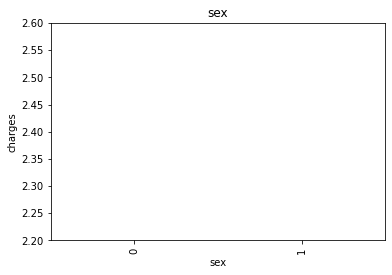

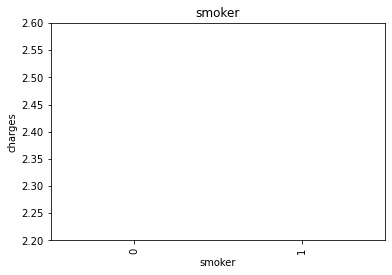

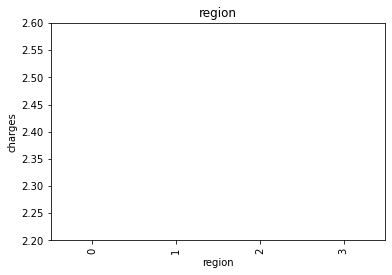

In [45]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(train, y_train, var):
    
    # function plots median house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, y_train], axis=1)
    
    tmp.groupby(var)[target].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel(target)
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

The monotonic relationship is particularly clear for the variables MSZoning and Neighborhood. Note how, the higher the integer that now represents the category, the higher the mean house sale price.

(remember that the target is log-transformed, that is why the differences seem so small).

In [46]:
X_train.head()

,age,sex,bmi,children,smoker,region
141,38,1,29.853845,3,1,2
487,46,0,33.416721,1,0,2
678,38,1,39.418259,0,1,3
49,41,0,38.707752,0,0,1
1179,62,0,32.776439,0,1,2


## Feature Scaling

For use in linear models, features need to be either scaled. We will scale features to the minimum and maximum values:

In [47]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [48]:
X_train.head()

,age,sex,bmi,children,smoker,region
0,0.444444,1.0,0.288594,0.6,1.0,0.666667
1,0.622222,0.0,0.438563,0.2,0.0,0.666667
2,0.444444,1.0,0.691180,0.0,1.0,1.000000
3,0.511111,0.0,0.661274,0.0,0.0,0.333333
4,0.977778,0.0,0.411612,0.0,1.0,0.666667


In [49]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)

In [50]:
# now let's save the scaler

joblib.dump(scaler, 'minmax_scaler.joblib') 

['minmax_scaler.joblib']

That concludes the feature engineering section.

# Additional Resources

- [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) - Online Course
- [Packt Feature Engineering Cookbook](https://www.packtpub.com/data/python-feature-engineering-cookbook) - Book
- [Feature Engineering for Machine Learning: A comprehensive Overview](https://trainindata.medium.com/feature-engineering-for-machine-learning-a-comprehensive-overview-a7ad04c896f8) - Article
- [Practical Code Implementations of Feature Engineering for Machine Learning with Python](https://towardsdatascience.com/practical-code-implementations-of-feature-engineering-for-machine-learning-with-python-f13b953d4bcd) - Article